## Imports

In [3]:
import pandas as pd
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
from torch import optim
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import torch
import torch.nn as nn
import torch.nn.functional as F
import csv

import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

random.seed(42)

## Data Preperation and processing

In [4]:
train=pd.read_csv("Train.csv")
train.describe() #reading all the data into pandas df

,UserID,ItemID
count,988129.000000,988129.000000
mean,3017.777691,1800.495898
std,1740.928305,1092.948991
min,1.000000,1.000000
25%,1508.000000,826.000000
50%,3016.000000,1756.000000
75%,4510.000000,2764.000000
max,6040.000000,3706.000000


In [5]:
random_test=pd.read_csv("RandomTest.csv")
random_test.describe()

,UserID,Item1,Item2
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,1804.040066,1805.266225
std,1743.742145,1086.962441,1097.934573
min,1.000000,1.000000,1.000000
25%,1510.750000,840.000000,814.000000
50%,3020.500000,1775.000000,1782.000000
75%,4530.250000,2764.250000,2776.500000
max,6040.000000,3706.000000,3706.000000


In [6]:
train.head()

,UserID,ItemID
0,1963,2102
1,1963,1156
2,1963,2555
3,1963,734
4,1963,307


In [7]:
random_test.head()

,UserID,Item1,Item2
0,1963,987,1436
1,5951,1080,872
2,1254,90,192
3,2738,3003,1945
4,3527,351,2744


In [8]:
popularity_test=pd.read_csv("PopularityTest.csv")
popularity_test.describe()

,UserID,Item1,Item2
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,1788.350497,1789.523013
std,1743.742145,1099.064304,1089.792969
min,1.000000,1.000000,1.000000
25%,1510.750000,782.000000,814.000000
50%,3020.500000,1733.500000,1707.000000
75%,4530.250000,2754.750000,2744.000000
max,6040.000000,3705.000000,3706.000000


In [9]:
popularity_test.head()

,UserID,Item1,Item2
0,1963,1503,2798
1,5951,1098,1511
2,1254,366,3523
3,2738,1546,197
4,3527,406,3527


In [10]:
#Creating a sparse matrix for representing the problem in a simple way
column = np.array(train["ItemID"])
row = np.array(train["UserID"])
takes = np.array(np.ones(len(train["ItemID"])))
train_matrix=csr_matrix((takes, (row, column)), shape=(max(train["UserID"])+1, max(train["ItemID"])+1)).toarray()
train_matrix.shape

(6041, 3707)

In [11]:
#validate and change!s
def get_batch(matrix,user_ids):
    return torch.tensor(matrix[user_ids,:]).to(torch.float32) #return batch accoarding to user id indicies

In [12]:
#splitting into train, validation and test sets- change!
train_users, val_users= train_test_split(range(train_matrix.shape[0]), test_size=0.2)
x_val=train_matrix[val_users,:]
x_train=train_matrix[train_users,:]
x_train, x_val=torch.tensor(x_train).to(torch.float32), torch.tensor(x_val).to(torch.float32)

In [13]:
class MakeBinarySet(Dataset):
    def __init__(self, uids,i1s,i2s):
        self.uids=torch.tensor(uids)
        self.i1s=torch.tensor(i1s)
        self.i2s=torch.tensor(i2s)
        
    def __getitem__(self, ind):
        return self.uids[ind], self.i1s[ind], self.i2s[ind]

    def __len__(self):
        return self.uids.size()[0] 

In [14]:
def get_binary_predictions(data_loader,net,train_matrix,in_loop=False):
    output_dict={}
    diff,strengths=[],[]
    quick_binary=[]
    net.eval()
    for user,i1,i2 in data_loader:
        x=torch.tensor(train_matrix[user,:]).to(torch.float32)
        with torch.no_grad():
            x_recon = net(x).T
            for user_ in range(len(user)): #for user in batch
                #print(x_recon[i1[user_].item()])
                if x_recon[i1[user_]][user_].item()>=x_recon[i2[user_]][user_].item(): #access user and item
                    output_dict[(int(user[user_]),int(i1[user_]),int(i2[user_]))]=0 #assign predictions to dictionary
                    quick_binary.append(0)
                else:
                    output_dict[(int(user[user_]),int(i1[user_]),int(i2[user_]))]=1 #assign predictions to dictionary
                    quick_binary.append(1)
                if not in_loop:
                    diff.append(float(x_recon[i1[user_]][user_].item()-x_recon[i2[user_]][user_].item()))
                    strengths.append(max(x_recon[i1[user_]][user_].item(),x_recon[i2[user_]][user_].item()))
    if not in_loop:
        return output_dict,diff,strengths
    else:
        return quick_binary
a=get_binary_predictions

In [15]:
train_matrix_c=np.copy(train_matrix)

In [16]:
#creating a binary set for traning the model. inserting one purchased item and non-purchased item. 
def creating_binary_dataloader(ind_list):
    global train_matrix_c
    u_id,i1,i2=[],[],[]
    for user in ind_list:
        if sum(train_matrix_c[user])!=0:
            max_val=np.random.choice([i for i, n in enumerate(train_matrix_c[user]) if n == 1],size=1)[0]
        else:
            max_val=0
        min_val=np.random.choice([i for i, n in enumerate(train_matrix_c[user]) if n == 0],size=1)[0]
        u_id.append(user)
        i1.append(max_val)
        i2.append(min_val)
        train_matrix_c[user][max_val]=0   
    data_set=MakeBinarySet(np.array(u_id),np.array(i1),np.array(i2))
    dl = DataLoader(data_set, batch_size=512, shuffle=False)
    return dl

In [17]:
val_dl_metric=creating_binary_dataloader(val_users)
train_dl_metric=creating_binary_dataloader(train_users)

## Creating AutoEncoder network

In [18]:
class Autoencoder(torch.nn.Module):
    def __init__(self,input_dimension):
        super().__init__()
          
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dimension, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9),
            torch.nn.Dropout(p=0.5)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, input_dimension),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
net=Autoencoder(train_matrix.shape[1])

In [19]:
class TabularDataset(Dataset):
    """ The dataset object used to read the data
    """
    def __init__(self, X):
        self.X = torch.tensor(X).to(torch.float32)
        
    def __getitem__(self, ind):
        user = self.X[ind, :]
        return user  

    def __len__(self):
        return self.X.shape[0] 

In [20]:
train_ds=TabularDataset(x_train)
val_ds=TabularDataset(x_val)

dataloader_train = DataLoader(train_ds, batch_size=16, shuffle=True)
dataloader_val = DataLoader(val_ds,batch_size=16 , shuffle=True)

C:\Users\gilad\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


### Training the model 

In [21]:
def infer(net, dataloader_loss, train_metric_dl,val_metric_dl,criterion):
    net.eval()
    running_loss = 0 
    test_set_answ=get_binary_predictions(val_metric_dl,net,train_matrix_c,in_loop=True)
    predictions=1-np.array(test_set_answ) #becuase in our case 0 is positive, unlike sci-kit learn, which expects 1.
    recall_val=recall_score(np.ones((len(predictions),)), predictions)
    
    test_set_answ=get_binary_predictions(train_metric_dl,net,train_matrix_c,in_loop=True)
    predictions=1-np.array(test_set_answ) #becuase in our case 0 is positive, unlike sci-kit learn, which expects 1.
    recall_train=recall_score(np.ones((len(predictions),)), predictions)
    #print("Recall:", np.round(recall,5))
    
    for x in dataloader_loss:
        with torch.no_grad():
            x_recon = net(x)
            loss = criterion(x_recon, x)
            loss=sum(loss)/x.size()[0] #in order to get avg cosine sim of the batch.
            running_loss +=  1-(loss.item()) #because we want to minimize
    return running_loss / len(dataloader_loss) , recall_val, recall_train

def training_loop(net=None,tr_dataloader=None,val_dataloader=None,train_metric_dl=None,val_metric_dl=None,criterion_func1=None,num_epochs=50, optimizer_func=optim.Adam,lamda=0.0,lr=0.001):
    criterion = criterion_func1()
    optimizer = optimizer_func(net.parameters(), lr=lr,weight_decay=lamda)
    tr_loss, val_loss, train_recall, val_recall = [None] * num_epochs, [None] * num_epochs, [None] * num_epochs, [None] * num_epochs
    for epoch in range(num_epochs):
        net.train()
        running_tr_loss = 0
        for x in tqdm(tr_dataloader):
            optimizer.zero_grad()
            x_recon = net(x) #forward pass
            recon_loss = criterion(x_recon, x)
            recon_loss=sum(recon_loss)/x.size()[0] #in order to get avg cosine sim of the batch
            loss = 1-recon_loss  #because we want to minimize
            loss.backward()
            optimizer.step()
            running_tr_loss += loss
        tr_loss[epoch] = running_tr_loss.item() / len(tr_dataloader)
        if val_dataloader and val_metric_dl:
            val_loss[epoch],val_recall[epoch],train_recall[epoch] = infer(net, val_dataloader,train_metric_dl,val_metric_dl, criterion) 
    if val_dataloader:
        return tr_loss,val_loss,val_recall,train_recall
    return tr_loss

In [22]:
#checking the optimal number of epochs to train the model
tr_loss,val_loss,val_recall,train_recall = training_loop(net,dataloader_train,dataloader_val,train_dl_metric,val_dl_metric,criterion_func1=nn.CosineSimilarity,num_epochs=300, lr=0.0001,)

100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [00:05<00:00, 56.88it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [00:05<00:00, 56.44it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [00:06<00:00, 48.27it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [00:05<00:00, 52.42it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [00:05<00:00, 51.80it/s]


### Plotting the results 

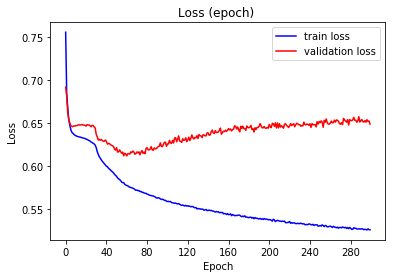

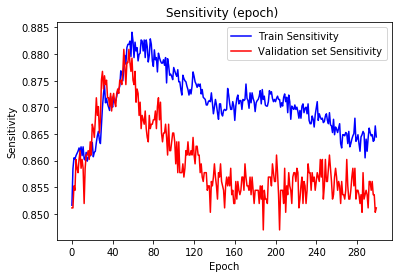

In [23]:
#plotting graphs to see what is the optimal number of epochs
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.plot(tr_loss,c='b',label="train loss")
ax.plot(val_loss,c='r',label="validation loss")
ax.set_title('Loss (epoch) ')

plt.legend()
plt.show()

ax = plt.figure().gca()
ax.plot(train_recall,c='b',label="Train Sensitivity");
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Sensitivity (epoch) ')

ax.plot(val_recall,c='r',label="Validation set Sensitivity")

ax.set_ylabel('Sensitivity')
ax.set_xlabel('Epoch')
plt.legend()
plt.show()


In [24]:
#choosing the ideal number of epochs
num_epochs_to_train=50

### Full training (complete dataset) 

In [25]:
#train the whole dataset and test set
all_dataset=TabularDataset(train_matrix)
total_dl = DataLoader(all_dataset, batch_size=16, shuffle=True)

In [26]:
net2=Autoencoder(train_matrix.shape[1])
training_loss = training_loop(net2,total_dl,num_epochs=num_epochs_to_train, lr=0.0001,criterion_func1=nn.CosineSimilarity)

100%|████████████████████████████████████████████████████████████████████████████████| 378/378 [00:06<00:00, 56.34it/s]


### Prediction part 

In [27]:
User_ids = torch.tensor(np.array(random_test["UserID"])) #get data
Items_1 = torch.tensor(np.array(random_test["Item1"]))
Items_2 = torch.tensor(np.array(random_test["Item2"]))

random_test_ds=MakeBinarySet(User_ids,Items_1,Items_2)
random_test_dl = DataLoader(random_test_ds, batch_size=2056, shuffle=False) #create test data loaders

User_ids = torch.tensor(np.array(popularity_test["UserID"]))
Items_1 = torch.tensor(np.array(popularity_test["Item1"]))
Items_2 = torch.tensor(np.array(popularity_test["Item2"]))

popularity_test_ds=MakeBinarySet(User_ids,Items_1,Items_2)
popularity_test_dl = DataLoader(popularity_test_ds, batch_size=2056, shuffle=False) 

C:\Users\gilad\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\gilad\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
C:\Users\gilad\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [28]:
random_test_res,diff_ran,stren1=get_binary_predictions(random_test_dl,net2,train_matrix) #predict
popularity_test_res,diff_pop,stren2=get_binary_predictions(popularity_test_dl,net2,train_matrix)


## Performance comparison 

In [29]:
dl_total=creating_binary_dataloader(range(train_matrix.shape[0]))

In [30]:
test_set_answ,diff_test,stren_test=get_binary_predictions(dl_total,net2,train_matrix_c)
predictions=1-np.array(list(test_set_answ.values())) #becuase in our case 0 is positive, unlike sci-kit learn, which expects 1.
recall=recall_score(np.ones((len(predictions),)), predictions)
print("Recall:", np.round(recall,5))


Recall: 0.88065


In [31]:
def compare_diffs(diff_lst_1,diff_lst_2,strength1,strength2):
    diff_lst_1=np.array(diff_lst_1)
    diff_lst_2=np.array(diff_lst_2)
    mu1,mu2=np.around(np.mean(np.abs(diff_lst_1)),6),np.around(np.mean(np.abs(diff_lst_2)),6)
    print("Mean absolute difference between predictions:\nRandom: {}\nPopularity: {}\n".format(mu1,mu2))
    sd1,sd2=np.around(np.std(np.abs(diff_lst_1)),6),np.around(np.std(np.abs(diff_lst_2)),6)
    print("Mean absolute difference's standard deviation:\nRandom: {}\nPopularity: {}\n".format(sd1,sd2))
    print("Mean Rand Test Signal Strength: {}\nMean Popularity Test Signal Strength: {}".format(np.around(np.mean(strength1),6),np.around(np.mean(strength2),6)))

In [32]:
compare_diffs(diff_ran,diff_pop,stren1,stren2)

Mean absolute difference between predictions:
Random: 0.222597
Popularity: 0.202437

Mean absolute difference's standard deviation:
Random: 0.204232
Popularity: 0.186927

Mean Rand Test Signal Strength: 0.256617
Mean Popularity Test Signal Strength: 0.286931


## Creating the files with predictions

In [33]:
torch.save(net2,"Our_AE_Params.pt")

In [34]:
def write_to_csv(data,fname):
    with open(fname, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["UserID","Item1","Item2","BitClassification"])
        for key,value in data.items():
            writer.writerow([key[0],key[1],key[2],value])

In [35]:
write_to_csv(random_test_res,'RandomTest_Results.csv')
write_to_csv(popularity_test_res,'PopularityTest_Results.csv')